# Deep Q-Learning on Mario Bros
<hr>
This is a reinforcement learning project on implementing a deep q-network and training it to play the Atari 2600 version of Mario Bros. Below is the notebook documenting training, experiments done, etc.

Let's create the gym environment

In [1]:
pip install "gymnasium[other]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import environment dependencies
import gymnasium as gym
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation, FrameStackObservation
import ale_py
from ale_py import ALEInterface

# import saved model
import torch

# import model
from dqn import DQN

# import plotting
import matplotlib.pyplot as plt

# import wandb for logging
import wandb

# import rendering
from IPython import display
from PIL import Image
import time

Here is some starter code to play around with the environment and API - get a feel for what is happening with the API and the wrapper.

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


6
Box(0, 255, (210, 160, 3), uint8)
False
<class 'numpy.int64'>
<class 'gymnasium.spaces.box.Box'>
<class 'bool'>
(210, 160, 3)
render type: <class 'numpy.ndarray'>


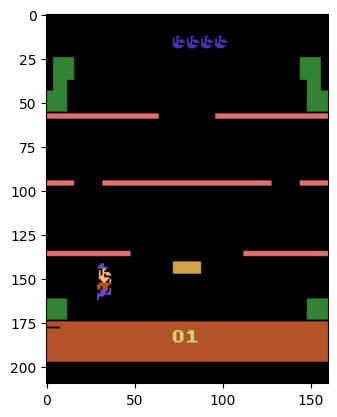

In [3]:
# let's create the environment to make sure it works
env_prac = gym.make(
    'ALE/MarioBros-v5', 
    obs_type = 'rgb',
    render_mode = 'rgb_array'
)

obs, info = env_prac.reset()
ACTION_SIZE = env_prac.action_space.n
ACTIONS = env_prac.action_space.sample()
OBSERVATIONS = env_prac.observation_space
obs, reward, terminated, truncated, info = env_prac.step(ACTIONS)

# print and log to see data types
print(ACTIONS)
print(OBSERVATIONS)
print(terminated)

print(type(ACTIONS))
print(type(OBSERVATIONS))
print(type(terminated))
print(env_prac.render().shape)

# render the image
img = plt.imshow(env_prac.render()) # only call this once
print('render type:', type(env_prac.render()))

env_prac.close()

In [4]:
# okay, let's actually start writing some code
rew_arr = [] # array holding rewards
episode_count = 100 # num episodes to train on

# instantiate the mario emulator gym
env = gym.make(
    'ALE/MarioBros-v5',
    obs_type = 'rgb',
    render_mode = 'rgb_array',
    frameskip = 5
)

# add framestacking, grayscale and resize for better temporal inferencing
    # indicated by previous model performance
env = GrayscaleObservation(env)
env = ResizeObservation(env, (84, 84))
env = FrameStackObservation(env, stack_size=4)

# reset environment
obs, info = env.reset()

#img = plt.imshow(env.render()) # only call this once
#obs = obs.transpose(0, 3, 1, 2).reshape(210, 160, 12)
print(f'Shape of observation: {obs.shape}')

Shape of observation: (4, 84, 84)


In [5]:
# set in-channels for cnn
in_channels = obs.shape[0]
print(f'In Channels for obs: {in_channels}')

# instantiate the model
dqn = DQN(env, in_channels, env.action_space.n)

In Channels for obs: 4


In [6]:
# init wandb logging 
wandb.login()

wandb.init(
    entity="zavierand-new-york-university",
    project='dqn-mario',
    config={
        'learning_rate': 1e-2,
        'architecture': 'DQN',
        'epochs': 5000,
    },
)

wandb: Currently logged in as: zavierand (zavierand-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Model's state_dict:
conv_layers.conv.0.weight 	 torch.Size([32, 4, 8, 8])
conv_layers.conv.0.bias 	 torch.Size([32])
conv_layers.conv.3.weight 	 torch.Size([64, 32, 4, 4])
conv_layers.conv.3.bias 	 torch.Size([64])
model.0.weight 	 torch.Size([512, 5184])
model.0.bias 	 torch.Size([512])
model.2.weight 	 torch.Size([18, 512])
model.2.bias 	 torch.Size([18])
target_model.0.weight 	 torch.Size([512, 5184])
target_model.0.bias 	 torch.Size([512])
target_model.2.weight 	 torch.Size([18, 512])
target_model.2.bias 	 torch.Size([18])
Rendering agent at episode 1000
Average Reward per Episode: 0.0


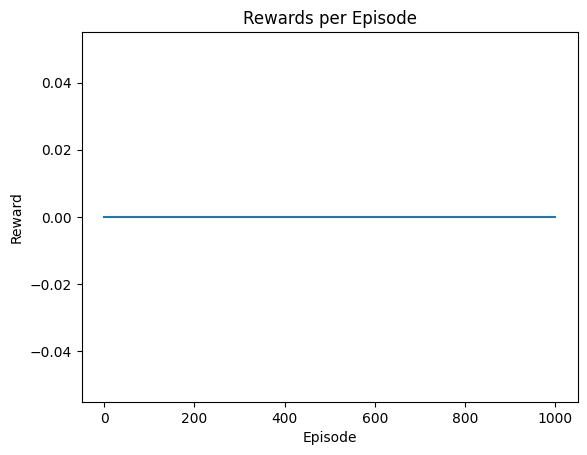

In [14]:
# load the trained model
checkpoint = torch.load('./checkpoints/train_02/dqn_checkpoint_epoch_4500.pt', map_location=torch.device('cpu'))

# print model parameters
print("Model's state_dict:")
for param_tensor in dqn.state_dict():
    print(param_tensor, "\t", dqn.state_dict()[param_tensor].size())

dqn.model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate the model's performance and capture frames
num_episodes = 1000
avg_reward, rewards, frames = dqn._eval(env, num_episodes, render=True)

# plot rewards per episode
plt.plot(rewards)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

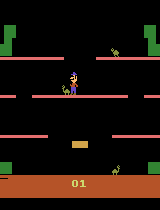

In [15]:
# animate model's performance for episodes that are a multiple of 1000
for frame in frames:
    display.display(Image.fromarray(frame))
    time.sleep(0.05)  # Adjust for speed of rendering
    display.clear_output(wait=True)

In [13]:
env.close()